Change to GPU Tesla T4

In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU - Change Runtime Type to GPU!")

!pip install -q --no-cache-dir open-clip-torch ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 324.1 MB/s eta 0:00:00


## Loading Dataset (Industrial [Mvtec AD])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

drive_root = "/content/drive/MyDrive/MVTec"
raw_dataset = f"{drive_root}/mvtec_anomaly_detection"
converted_dataset = f"{drive_root}/mvtec_imagefolder"

print("Raw dataset path:", raw_dataset)
print("Converted ImageFolder path:", converted_dataset)

Mounted at /content/drive
Raw dataset path: /content/drive/MyDrive/MVTec/mvtec_anomaly_detection
Converted ImageFolder path: /content/drive/MyDrive/MVTec/mvtec_imagefolder


In [ ]:
import torch
import open_clip
import os
from peft import PeftModel
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device.upper()}")

# Load CLIP
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion400m_e31')
model.to(device).eval()
tokenizer = open_clip.get_tokenizer('ViT-B-16')


Running on CUDA


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Found 15 valid MVTec classes (excluded junk folders):
['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Total test images collected: 1725
Building object text classifier...
Running inference on MVTec objects...


Predicting:   0%|          | 0/27 [00:00<?, ?it/s]


 ZERO-SHOT ACCURACY: 68.99% (on clean MVTec 15 object/texture classes)


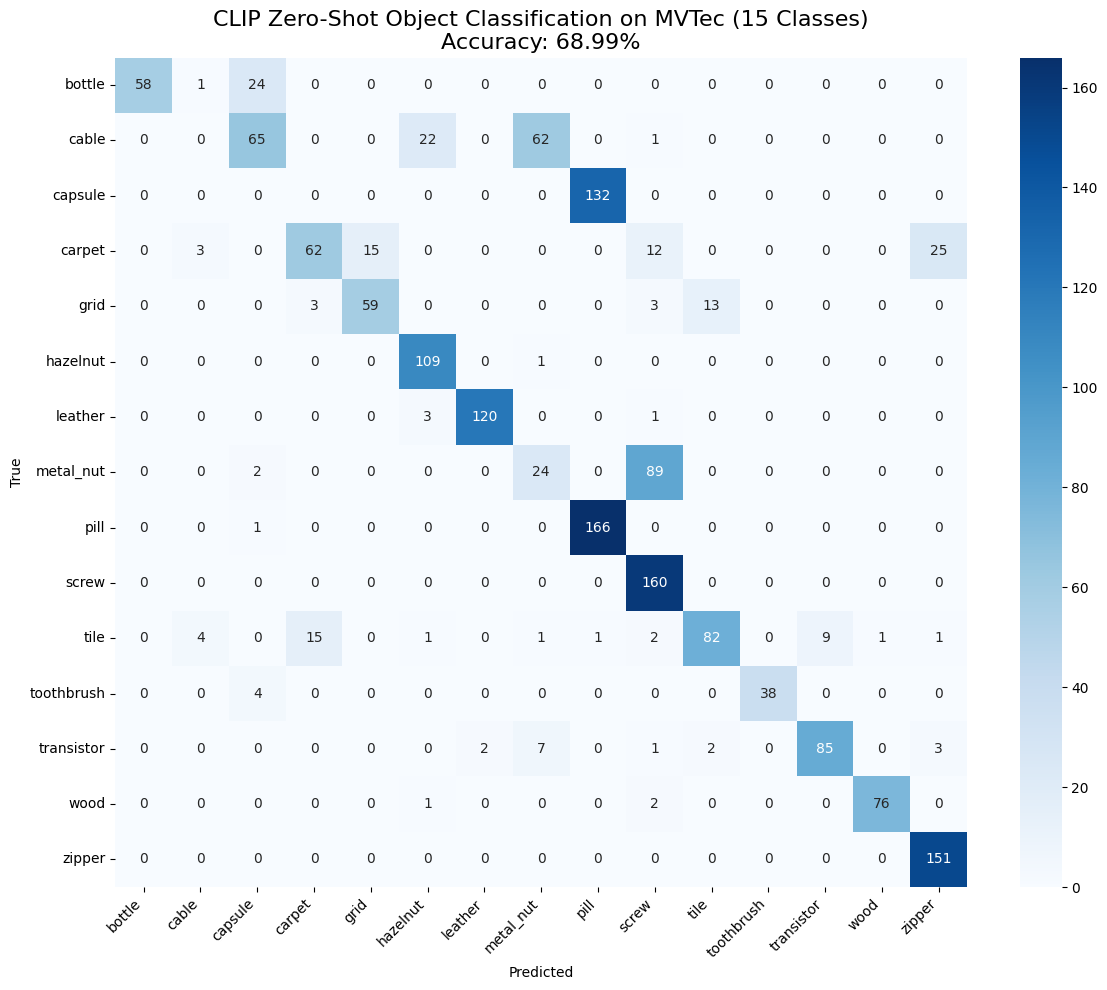


Detailed Report:
              precision    recall  f1-score   support

      bottle     1.0000    0.6988    0.8227        83
       cable     0.0000    0.0000    0.0000       150
     capsule     0.0000    0.0000    0.0000       132
      carpet     0.7750    0.5299    0.6294       117
        grid     0.7973    0.7564    0.7763        78
    hazelnut     0.8015    0.9909    0.8862       110
     leather     0.9836    0.9677    0.9756       124
   metal_nut     0.2526    0.2087    0.2286       115
        pill     0.5552    0.9940    0.7124       167
       screw     0.5904    1.0000    0.7425       160
        tile     0.8454    0.7009    0.7664       117
  toothbrush     1.0000    0.9048    0.9500        42
  transistor     0.9043    0.8500    0.8763       100
        wood     0.9870    0.9620    0.9744        79
      zipper     0.8389    1.0000    0.9124       151

    accuracy                         0.6899      1725
   macro avg     0.6887    0.7043    0.6835      1725
weighted

In [13]:
from pathlib import Path

data_root = None
for p in ["/content/drive/MyDrive/mvtec_anomaly_detection"]:
    if Path(p).exists():
        data_root = Path(p)
        break
if data_root is None:
    raise FileNotFoundError("MVTec dataset folder not found! Please check the path.")

# Folders to completely ignore
exclude_folders = {
    '.git',
    'autoencoder',
    'mvtec-anomaly-detection-full',
    'processing',
    'results',
    'saved_models'
}

# Collect only the real 15 MVTec categories
raw_categories = [d for d in data_root.iterdir() if d.is_dir()]
classes = sorted([d.name for d in raw_categories if d.name not in exclude_folders])

print(f"Found {len(classes)} valid MVTec classes (excluded junk folders):")
print(classes)

# Collect test images from all valid categories
test_samples = []
label_map = {cls: idx for idx, cls in enumerate(classes)}

print("Collecting MVTec test images for object classification...")

for category in raw_categories:
    cat_name = category.name
    if cat_name in exclude_folders:
        print(f"Skipping excluded folder: {cat_name}")
        continue

    test_dir = category / "test"
    if not test_dir.exists():
        continue

    for subfolder in test_dir.iterdir():
        if subfolder.is_dir():
            for img_path in subfolder.glob("*.png"):
                test_samples.append((str(img_path), label_map[cat_name]))

print(f"Total test images collected: {len(test_samples)}")
random.shuffle(test_samples)

# Dataset class (unchanged)
class MVTecTestDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert("RGB")
            return preprocess(img), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return preprocess(Image.new('RGB', (224, 224), color='black')), torch.tensor(0)

# Loader
test_dataset = MVTecTestDataset(test_samples)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Tailored prompts for object names
templates = [
    "a photo of a {}.",
    "a close-up photo of a {}.",
    "an industrial photo of a {}.",
    "a high-resolution image of a {}.",
    "a manufactured {}.",
    "a product image of a {}.",
    "a quality control photo of a {}.",
    "a frontal view of a {}.",
    "an image showing a {}."
]

# Build text features
print("Building object text classifier...")
text_features = []
with torch.no_grad():
    for c in classes:
        display_name = c.replace("_", " ")  # e.g., "metal nut"
        texts = [t.format(display_name) for t in templates]
        tokens = tokenizer(texts).to(device)
        emb = model.encode_text(tokens)
        emb /= emb.norm(dim=-1, keepdim=True)
        text_features.append(emb.mean(dim=0))
text_features = torch.stack(text_features)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Zero-shot inference (unchanged)
print("Running inference on MVTec objects...")
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(device)
        img_feat = model.encode_image(imgs)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        sim = (100.0 * img_feat @ text_features.T).softmax(dim=-1)
        pred = sim.argmax(dim=-1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(labels.numpy())

# Results
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
acc = accuracy_score(all_labels, all_preds)
print(f"\n ZERO-SHOT ACCURACY: {acc*100:.2f}% (on clean MVTec 15 object/texture classes)")

# Confusion matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'CLIP Zero-Shot Object Classification on MVTec (15 Classes)\nAccuracy: {acc*100:.2f}%', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nDetailed Report:")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

## LoRA

In [ ]:
# BUILD TRAIN DATASET (from train/good only)
train_samples = []

for category in raw_categories:
    cat_name = category.name
    if cat_name in exclude_folders:
        continue

    train_dir = category / "train" / "good"
    if train_dir.exists():
        for img_path in train_dir.glob("*.png"):
            train_samples.append((str(img_path), label_map[cat_name]))

print(f"Total TRAIN images collected: {len(train_samples)}")

train_dataset = MVTecTestDataset(train_samples)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)


Total TRAIN images collected: 3630


In [ ]:
from peft import LoraConfig, get_peft_model

vision_encoder = model.visual

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION",
    target_modules=[
        "in_proj_weight",
        "in_proj_bias",
        "out_proj"
    ]
)

vision_encoder = get_peft_model(vision_encoder, lora_config)
vision_encoder.to(device)
vision_encoder.print_trainable_parameters()

trainable params: 294,912 || all params: 86,487,552 || trainable%: 0.3410


Load the LoRA

In [ ]:
from peft import PeftModel
import torch.nn as nn

# 1. Load the BASE CLIP model first
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

# 2. Load the LoRA adapters into the vision brain
save_path = "/content/drive/MyDrive/mvtec_lora_model"
vision_encoder = PeftModel.from_pretrained(model.visual, save_path)
vision_encoder.to(device)

# 3. Re-create the classifier and load its weights
classifier = nn.Linear(model.visual.output_dim, 15).to(device)
classifier.load_state_dict(torch.load(os.path.join(save_path, "classifier_head.pt")))

vision_encoder.eval()
classifier.eval()
print("Model loaded! You can now jump straight to Evaluation.")

open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Model loaded! You can now jump straight to Evaluation.


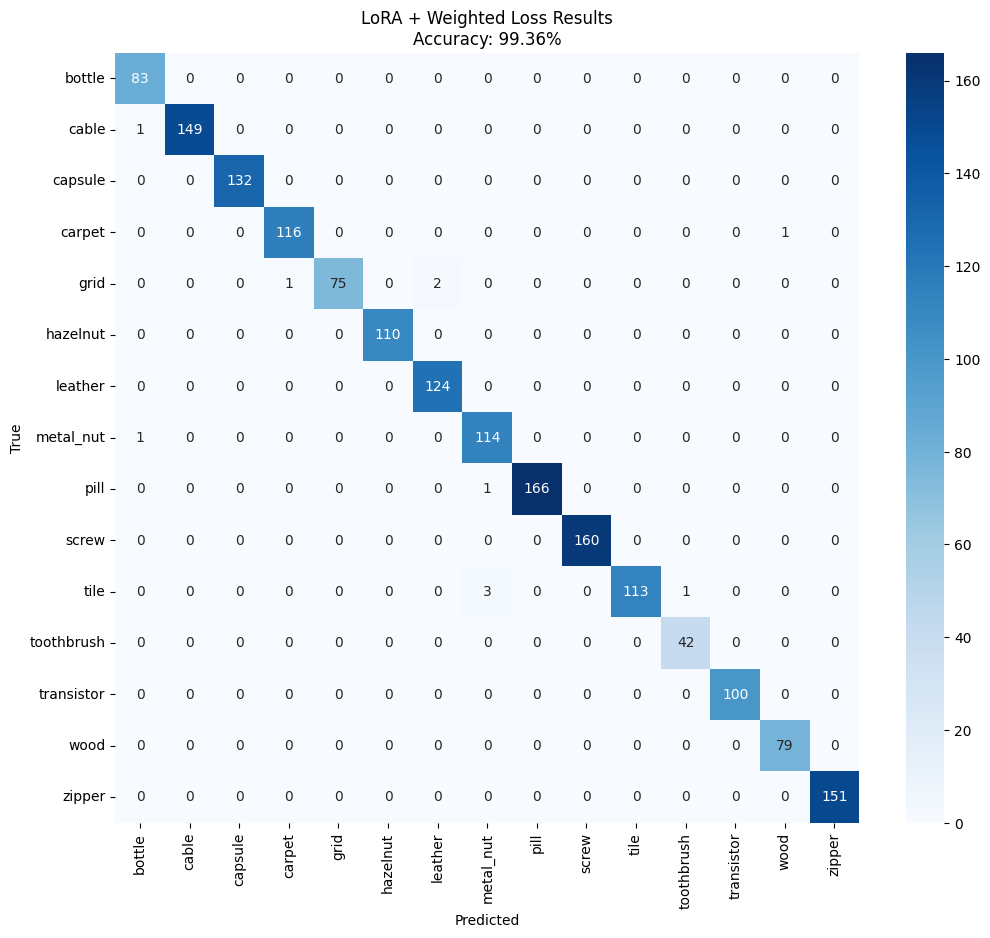

              precision    recall  f1-score   support

      bottle       0.98      1.00      0.99        83
       cable       1.00      0.99      1.00       150
     capsule       1.00      1.00      1.00       132
      carpet       0.99      0.99      0.99       117
        grid       1.00      0.96      0.98        78
    hazelnut       1.00      1.00      1.00       110
     leather       0.98      1.00      0.99       124
   metal_nut       0.97      0.99      0.98       115
        pill       1.00      0.99      1.00       167
       screw       1.00      1.00      1.00       160
        tile       1.00      0.97      0.98       117
  toothbrush       0.98      1.00      0.99        42
  transistor       1.00      1.00      1.00       100
        wood       0.99      1.00      0.99        79
      zipper       1.00      1.00      1.00       151

    accuracy                           0.99      1725
   macro avg       0.99      0.99      0.99      1725
weighted avg       0.99   

In [ ]:
vision_encoder.eval(); classifier.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = vision_encoder(imgs)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        all_preds.extend(classifier(feats).argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

#Results
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f"LoRA + Weighted Loss Results\nAccuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

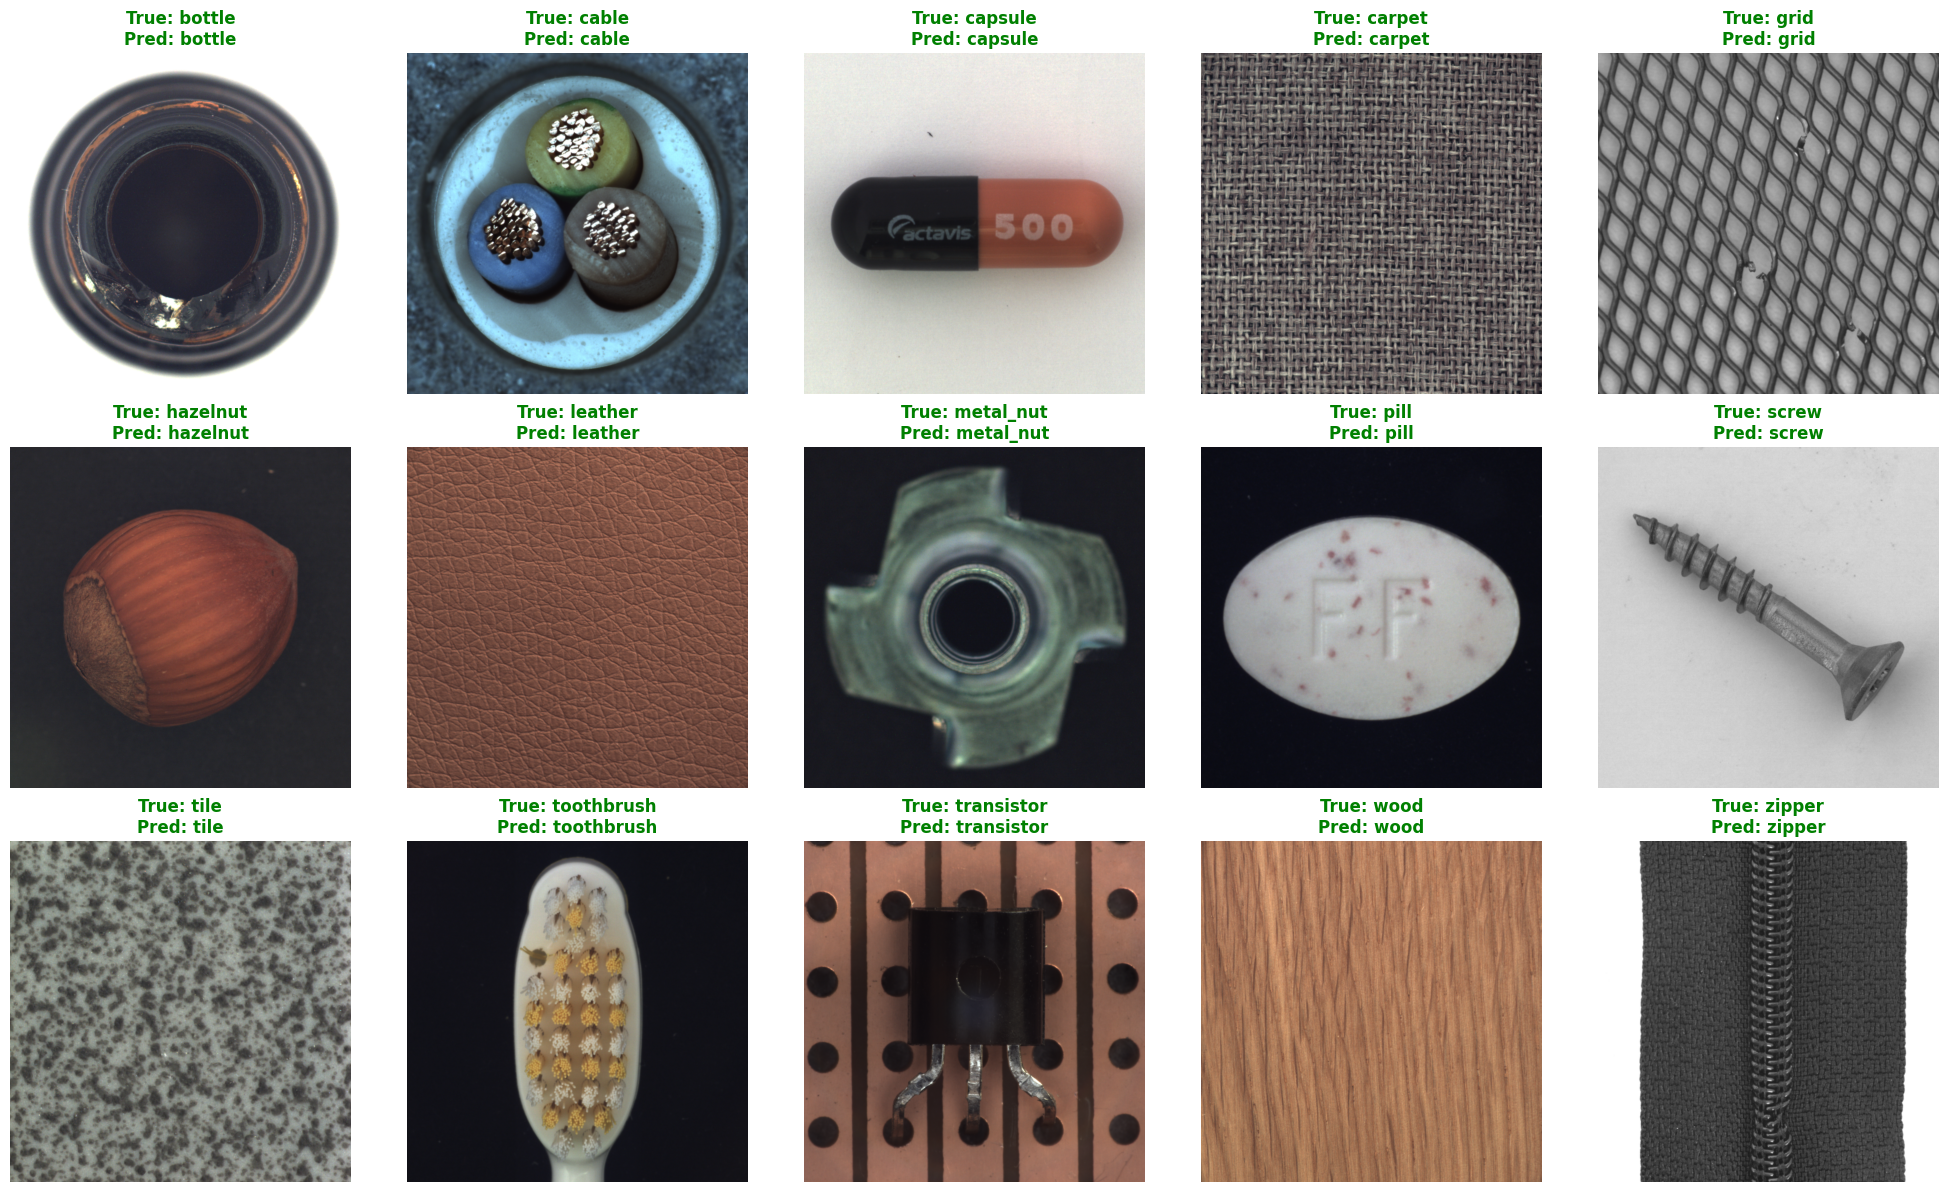

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from pathlib import Path

mvtec_classes = [
    'bottle', 'cable', 'capsule', 'carpet', 'grid',
    'hazelnut', 'leather', 'metal_nut', 'pill', 'screw',
    'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
]


class_examples = {}

for sample in test_samples:
    path = sample[0]
    true_name = Path(path).parents[2].name.lower()

    if true_name not in class_examples:
        class_examples[true_name] = path

    if len(class_examples) == 15:
        break

#Plot the 15 images in a 3x5 grid
plt.figure(figsize=(20, 12))
vision_encoder.eval()
classifier.eval()

sorted_keys = sorted(class_examples.keys())

with torch.no_grad():
    for i, class_name in enumerate(sorted_keys):
        img_path = class_examples[class_name]
        img = Image.open(img_path).convert("RGB")

        img_t = preprocess(img).unsqueeze(0).to(device)
        feat = vision_encoder(img_t)
        feat /= feat.norm(dim=-1, keepdim=True)
        logits = classifier(feat)
        pred_idx = logits.argmax(1).item()
        pred_name = mvtec_classes[pred_idx]

        # Setup subplot (3x5)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)

        # Color: Green if prediction matches the folder name
        color = 'green' if class_name == pred_name.lower() else 'red'

        plt.title(f"True: {class_name}\nPred: {pred_name}", color=color, fontsize=12, fontweight='bold')
        plt.axis('off')

plt.tight_layout()
plt.show()